In [1]:

import os
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import templates

In [2]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

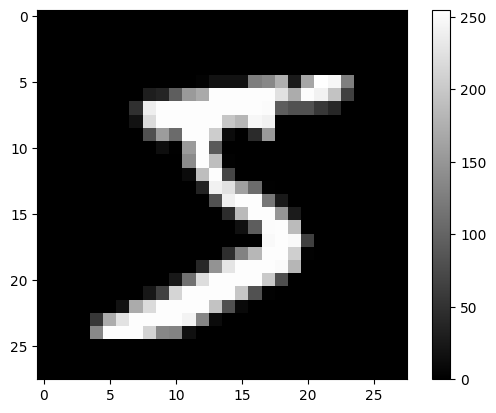

In [3]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [4]:
class InputShapeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.input_shapes = []

    def on_epoch_end(self, epoch, logs=None):
        
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                input_shape = layer.input_shape
                self.input_shapes.append((layer.name, input_shape))
                print(f"Layer: {layer.name}, Input shape: {input_shape}")

In [5]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
# model.add(tf.keras.layers.Flatten())
# # model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 17s 17ms/step - loss: 0.6551 - accuracy: 0.9079
Epoch 2/6
938/938 [==============================] - 16s 17ms/step - loss: 0.5013 - accuracy: 0.9574
Epoch 3/6
938/938 [==============================] - 16s 17ms/step - loss: 0.4765 - accuracy: 0.9644
Epoch 4/6
938/938 [==============================] - 16s 18ms/step - loss: 0.4685 - accuracy: 0.9661
Epoch 5/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4591 - accuracy: 0.9708
Epoch 6/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4570 - accuracy: 0.9705


In [6]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 2s 5ms/step - loss: 0.5120 - accuracy: 0.9691
+sequential stats-----------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                        x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------------+
| quant_conv2d                     1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| max_pooling2d                    -  (-1, 12, 12, 32)        0         0       0           0 |
| batch_normalization              -  (-1, 12, 12, 32)        0        64    0.25           0 |
| quant_conv2d_1                   1  (-1, 10, 10, 32)     9216         0    1.12      921600 |
| max_pooling2d_1                  -    (-1, 5, 5, 32)        0         0       0           0 |
| batch_normalization_1            -    (-1, 5,

In [7]:
# # Extract weights
# with lq.context.quantized_scope(True):
#     weights = model.layers[3].get_weights()
#     print(weights)

#     if len(weights) > 0:
#         weight_array = weights[0] 
#         print("Weights shape:", weight_array.shape)
#     else:
#         print("No weights found in this layer.")

# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        print(f"Layer: {layer.name}")
        print(f"  Beta (offset): {beta}")
        print(f"Beta Length: {len(beta)}")
        print(f"  Moving Mean: {moving_mean}")
        print(f" Moving Mean Length: {len(moving_mean)}")
        print(f"  Moving Variance: {moving_variance}")
        print(f"  Moving Variance Length: {len(moving_variance)}")

Layer: batch_normalization
  Beta (offset): [-0.2628228   0.15782718 -0.5284099  -0.74273616 -0.45367378 -0.10186193
  0.08579124 -0.6890928  -0.32662195  0.09673755 -0.5273635  -0.30948326
  0.0630685  -0.08210813 -0.10889392 -0.8415992  -0.01688982  0.08890344
 -0.9302154  -0.5355635  -0.2334577  -0.2172808   0.33246627 -0.4725801
 -0.42205152 -0.5039059  -0.4523534  -0.35837477 -0.19038872 -0.29852945
 -0.17643832 -0.17784601]
Beta Length: 32
  Moving Mean: [ 3.4323437e+00 -2.1056681e+00  5.5281539e+00  2.1725578e+00
  4.9445000e+00 -2.2714612e+00 -4.3038783e+00  1.6431963e+00
  6.5336823e+00  9.8812485e-01  5.5441184e+00  4.4932141e+00
  1.3896981e+00  1.4919758e+00  4.9273195e+00  2.0640695e-03
  4.0103827e+00 -9.1125751e-01  3.0586777e+00  3.6862829e+00
  2.3022871e+00 -3.2105241e+00  1.7149311e-01  4.7599645e+00
  3.0859766e+00  7.0029445e+00  6.4772539e+00  3.4938393e+00
 -8.4544577e-02  4.9399252e+00 -2.8701439e+00  3.1680629e+00]
 Moving Mean Length: 32
  Moving Variance: [13

In [8]:
input_shape_callback = InputShapeCallback()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        input_shape = layer.input_shape
        print(f"Layer: {layer.name}, Input shape: {input_shape}")

Layer: batch_normalization, Input shape: (None, 12, 12, 32)
Layer: batch_normalization_1, Input shape: (None, 5, 5, 32)
Layer: batch_normalization_2, Input shape: (None, 128)
Layer: batch_normalization_3, Input shape: (None, 10)


In [9]:
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")

# Extract weights
betas = []
moving_means = []
moving_variances = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        betas.append(beta)
        moving_means.append(moving_mean)
        moving_variances.append(moving_variance)

In [10]:
def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    compare = ""
    for output_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[output_neuron] - beta[output_neuron] * np.sqrt(moving_variance[output_neuron])
        compare += f"   assign o_data[{output_neuron}] = i_data[{output_neuron}] > {threshold} ? 1 : 0;\n"

    output_hdl = templates.BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/bn_layer_{num}.v", "w") as f:
        f.write(output_hdl)

In [11]:
for n in range(len(betas)):
    parse_bn(betas[n], moving_means[n], moving_variances[n], n)


In [18]:

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")


model_new = tf.keras.models.Sequential()


input_shape = (28, 28, 1)


model_new.add(tf.keras.layers.Flatten(input_shape=input_shape))

# # 128 neurons
# model_new.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
# model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 64 neurons
model_new.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 32 neurons
model_new.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 10 neurons
model_new.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

model_new.add(tf.keras.layers.Activation("softmax"))

model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_new.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 3s 3ms/step - loss: 0.7957 - accuracy: 0.8504
Epoch 2/6
938/938 [==============================] - 2s 2ms/step - loss: 0.6196 - accuracy: 0.9059
Epoch 3/6
938/938 [==============================] - 2s 3ms/step - loss: 0.5825 - accuracy: 0.9164
Epoch 4/6
938/938 [==============================] - 2s 3ms/step - loss: 0.5620 - accuracy: 0.9234
Epoch 5/6
938/938 [==============================] - 2s 2ms/step - loss: 0.5481 - accuracy: 0.9290
Epoch 6/6
938/938 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.9328


In [19]:
test_loss, test_acc = model_new.evaluate(test_images, test_labels)
lq.models.summary(model_new)

313/313 [==============================] - 0s 1ms/step - loss: 0.5048 - accuracy: 0.9376
+sequential_4 stats---------------------------------------------------------------------+
| Layer                   Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                               (bit)                 x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------+
| flatten_4                         -  (-1, 784)        0         0       0           0 |
| quant_dense_12                    1  (-1, 128)   100352         0   12.25      100352 |
| batch_normalization_14            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_13                    1  (-1, 128)    16384         0    2.00       16384 |
| batch_normalization_15            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_14                    1   (-1, 10)     1280         0    0.16        1280 |
| batch_nor